## 分类问题 - 非线性问题

---

在前面演示 PyTorch 基本流程的模型中，实现了一个线性回归的模型。那么现在思考一个问题：线性回归的模型是否能学习所有的数据集？

从理性来说，如果问题的类型是非线性的，那么就无法用线性模型来解决。例如：分类问题，识别某个图片中是猫还是狗？给定两个圆，判断某个点属于哪个圆上的点？

但是，从深度学习的原理来看，它其实也是画了一条线（函数线），用来对事物进行分类。例如下图中，模型经过学校，可能总结出来一个函数，该函数用来对图片进行分类，如果图片转换成数字形式后落在线上的部分，那么该图片里是猫，如果落在线的下方，就是狗。

在实际的情况下，这个函数曲线当然可能是千奇百怪的：

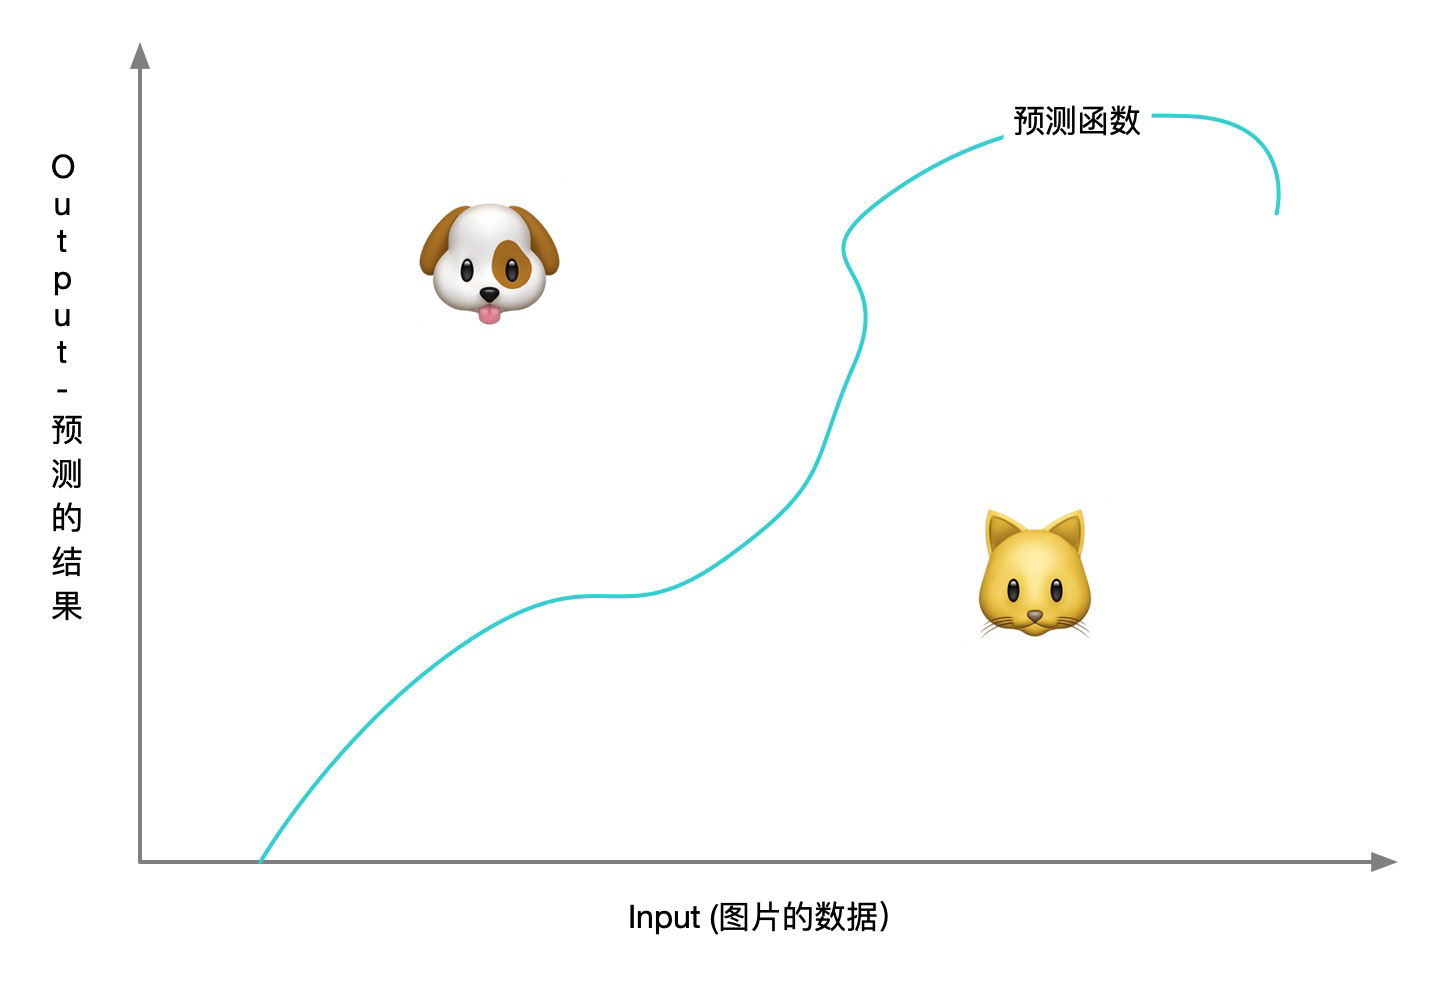

但是在某些情况下，也有可能使用一条直线就可以区分两种不同的事物。为了举例方便，假设我们要用人工智能解决一个简单问题：预测小孩是否能上小学。假设影响小孩是否能上小学的唯一变量是年龄要满 6 周岁。于是我们用成千上万的小孩的数据对模型进行训练，然后模型帮我们找出一个分类函数。对于这种问题，模型最后可能找出来的函数就是一条直线：

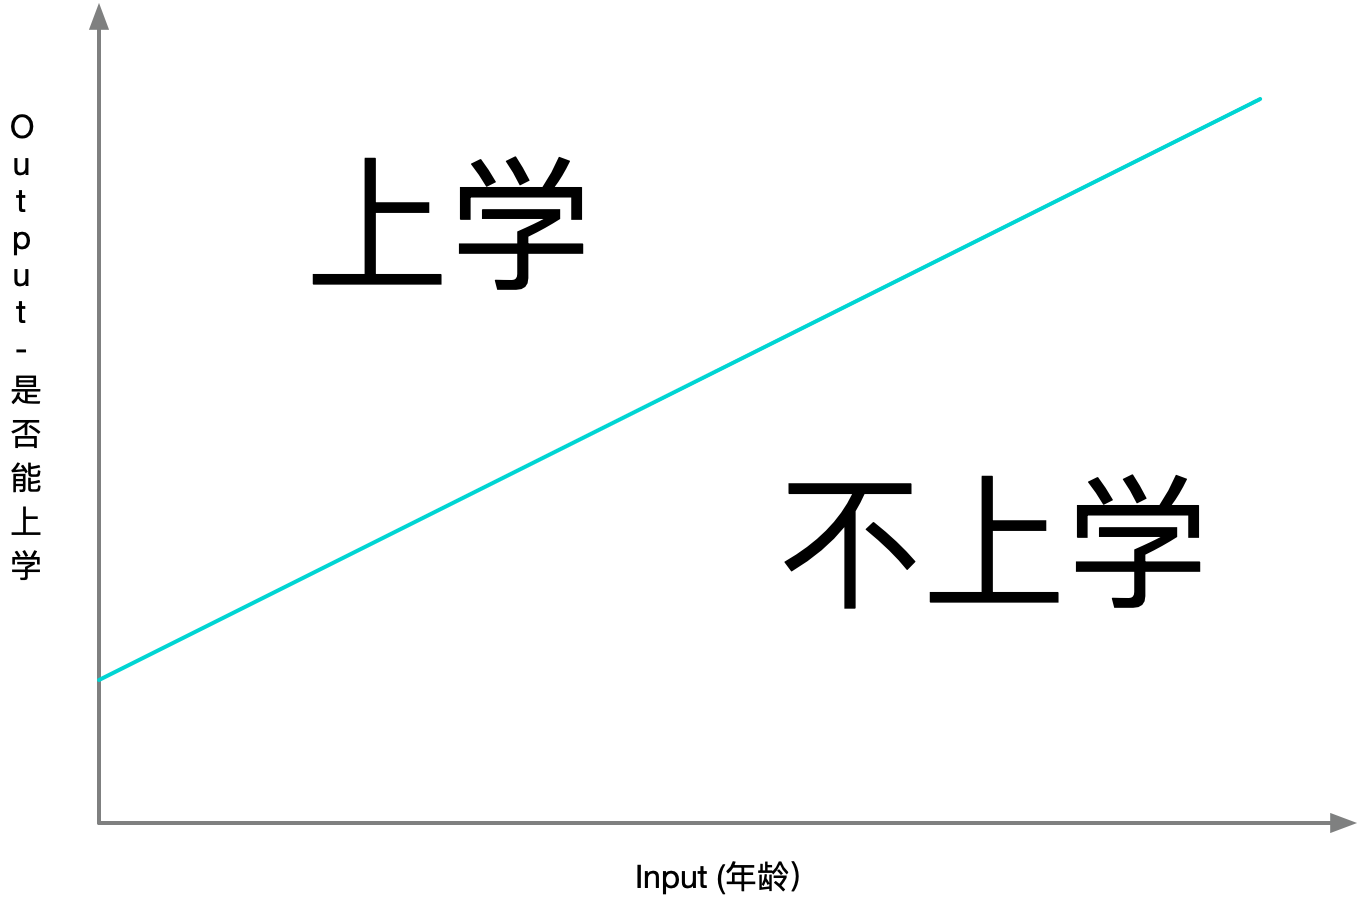

因此，有合理的理由可以假设线性模型也能处理一些分类问题。

但是，对于某些分类问题，可能是用线性模型无法处理的。例如：有两个同心圆，判断一个点会落在外圆还是内圆上。这种分类问题，如果用一条直线作为划分的依据，无论将直线画在哪个位置，都不能将两个圆区分开来，唯一能区分 2 个圆的，是位于两个圆之间的一条曲线：

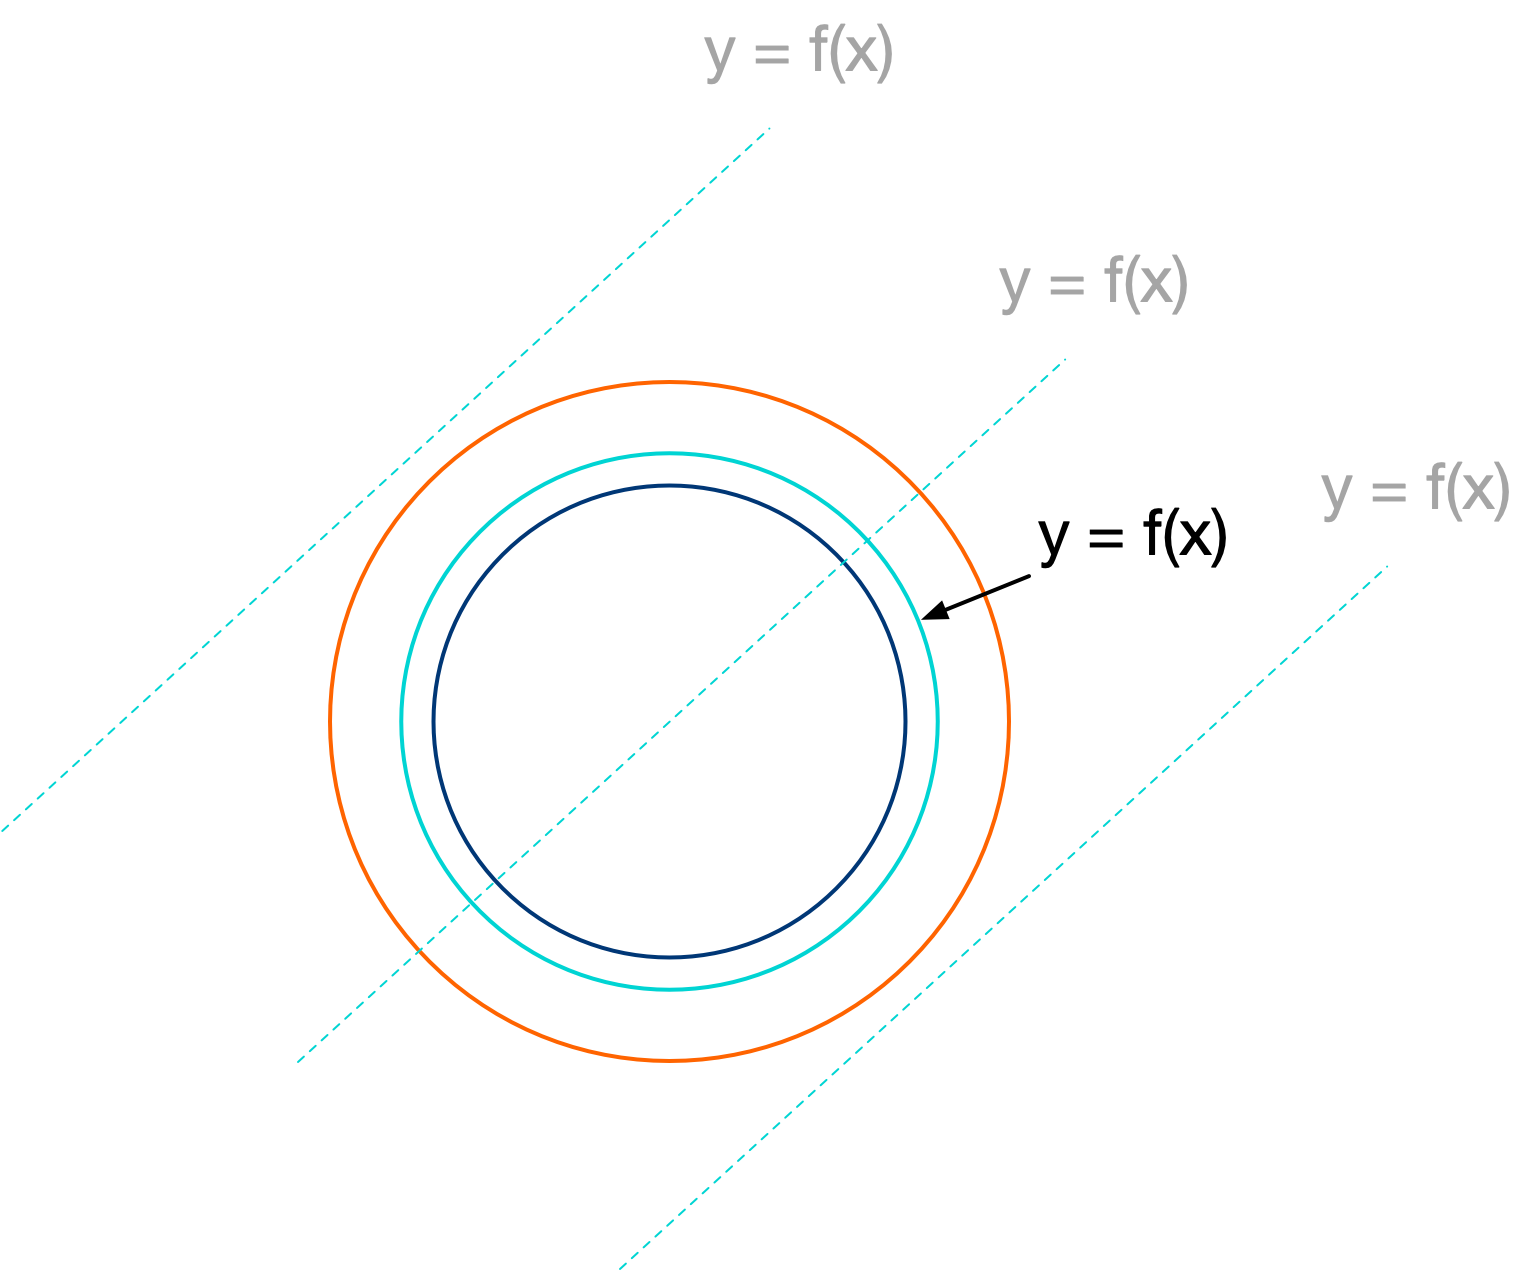

因此，线性模型理论上无法处理这一类的问题。这类问题需要非线性模型来进行处理。


### 线性模型解决分类问题的例子

---

后面的例子中，我们先构造一个分类问题，然后尝试用前面的线性模型来处理。验证是否能使用前面的线性模型来解决分类问题。

用前面创建的模型解决分类问题，我们需要做一点小小的修改。因为之前的模型的输出是数字，是处理回归问题（预测数字）的。现在要改成分类问题，则需要将其 loss 函数修改为适用于本例的 Binary Classification 的 `binary cross entropy` 函数。但它跟前面所用的 MAE 函数都有类似的作用：即评判预测值与期望值之间的差距有多大。

我们首先构造一个数据集，这个数据集就用来提醒之前小孩上学的例子：

In [1]:
import numpy as np
import torch

# 随机生成 1000 个年龄数据： 0~90 岁之间
data_size = 1000
X = np.random.randint(0, 90, size=(data_size))

# 生成对应的 label 数据
y = (X >= 6)          # 6 岁以上允许上小学

# 将 numpy 数组转换为 torch 的 tensor
X = torch.Tensor(X).unsqueeze(dim=1)
y = torch.Tensor(y).unsqueeze(dim=1)

# 将数据拆分为训练集和测试集
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

# 检查 GPU 加速设备是否可用
dev = "mps" if torch.has_mps else "cuda" if torch.has_cuda else "cpu"

# 如果 GPU 可用数据送入 GPU
X_train, y_train = X_train.to(dev), y_train.to(dev)
X_test, y_test = X_test.to(dev), y_test.to(dev)

In [2]:
len(X_train), len(y_train), len(X_test), len(y_test)

(800, 800, 200, 200)

将数据进行可视化：

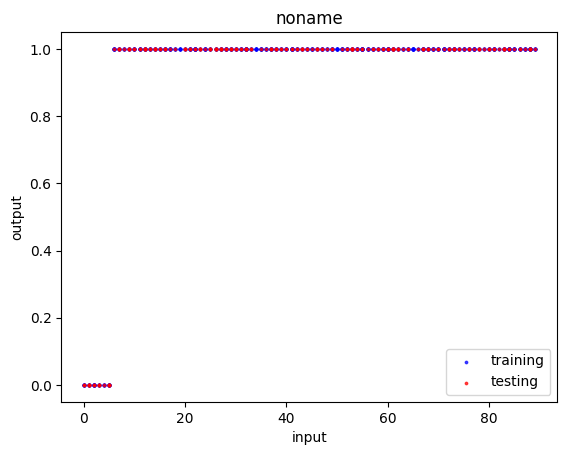

In [3]:
import matplotlib.pyplot as plt

def plot(x, y, color = "blue", legend = 'y', title='noname', xlabel='input', ylabel='output'):
    plt.scatter(x, y, c=color, s=3, label=legend, alpha=0.7)
    plt.legend()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

plot(X_train.cpu(), y_train.cpu(), color="blue", legend="training")
plot(X_test.cpu(), y_test.cpu(), color="red", legend="testing")

从输出的图中可以看出来，6 岁以上的输出都是 0，以下的都是 0。因此，模型通过学习，只需要找到一种函数，在 6 岁的位置上画出一条竖线就可以实现完美的分类。

现在数据集已经构造完成，把前面的线性回归的模型载入：

In [4]:
import torch
from torch import nn  # nn contains all of PyTorch's building blocks for neural networks

# 创建模型
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear() for creating the model parameters
        self.linear_layer = nn.Linear(in_features=1, out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)
    
# 将模型送入 GPU 加速
model = LinearRegressionModel()
model.to(dev)

LinearRegressionModel(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

模型创建后，用相同的步骤创建 loss 函数和 optimizer。但这里需要调整的是 loss function。不同的 loss function 适用于不同的问题，我们这里的问题是一个二分分类问题，因此应该使用 `binary cross entropy`，PyTorch 提供的 BCEWithLogitsLoss 或 BCELoss 就是 `binary cross entropy` 的实现。这里我们使用 BCEWithLogitsLoss，因为它包含了 sigmoid 函数。

至于 optimizer，线性回归问题和分类问题都可以使用 SGD 或者 Adam，我们使用 SGD。

In [5]:
# Create a loss function
# loss_fn = nn.BCELoss()
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model.parameters(), 
                            lr=0.03)

对于分类问题，还有一点不同是在于对结果的正确性量化评估，即准确度 accuracy。loss 函数可以从数字的角度评估每次预测与期望值的差距，而 accuracy 则分析多次预测中正确的次数和总的次数之比。为此我们需要创建一个 accuracy 函数：

In [6]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

在定义了模型，loss 函数和 optimizer 以及 accuracy 函数后，就可以开始训练循环了。分类问题的训练循环和线性回归是一样的，都遵循 PyTorch 基本流程。

但在进行训练之前，我们先要搞清楚一个重要的问题：究竟训练模型输出的是什么？为此我们可以先使用未经训练的模型进行试预测:

In [7]:
model.eval()
with torch.inference_mode():
    test_logits = model(X_test).squeeze()
    print(test_logits[:3])

tensor([15.3040,  0.7272, 28.6133], device='mps:0')


上面的例子我们输出了前 3 个预测结果。可以看到，模型输出的是一些数字。这些数字就是模型的预测结果。这些数字其实就是 forward 函数的返回值。

这些返回值在线性回归中是有意义的，因为它可以用 MAE 函数（L1Loss）与预期值直接比较，权衡两者的差距，因为它们是同一“级别”的数字。

但在这里的分类问题中，我们需要的是 0 到 1 之间的数字，即：上学还是不上学的概率。因此，我们需要有一种方法，或者一种函数，将这些预测结果数字转换为概率。而这个转换函数，就叫做“激活函数”（Activation Function）。

**Activation Function**

---

简单的解释，Activation Function 就是一个决定是否要激活下一层神经元的函数。具体讲，可以是将数字压缩到某个区间以内的函数：例如 sigmoid() 函数，将所有的数字压缩到 0~1 之间，从而使它可以表达概率。也可以是某种阈值的函数：例如 ReLU() 函数将所有大于 0 的数字都保持不变，而所有小于 0 的数字都变成 0。

---

**logits**

---

在未经过 Activation Function 转换之前的模型输出，被叫做 Raw Output，这种原始输出还有个学名，叫做 **logits**。在定义 loss 函数的时候，我们已经看到了 logits 这个术语。在其后的代码中一旦看到 logits，就代表未经转换的原始输出数据。

---

理解了 Activation Function 之后，后面的训练循环中，我们就可以使用 sigmoid() 函数来进行预测了。

分类问题的训练循环和回归问题是一样的，需要注意的是代码中使用了 sigmoid() 函数将 logits 转换为概率，然后又用 round 函数将概率转换为 0 和 1 的最终预测结果。

而具体地讲：
- logits 是模型的原始输出，被 loss 函数 BCEWithLogitsLoss 用来计算与期望值的误差。而期望值保存在 y_train 和 y_test 中，是 0 或 1，与 logits 不能直接比较，因此我们选择了自带 sigmoid 函数的 loss function：即 BCEWithLogitsLoss，它会自动使用 sigmoid 将 logits 转换为可以与 0 和 1 比较的概率。PyTorch 还有一个 loss function 叫 BCELoss，它不带 sigmoid，如果使用 BCELoss，就需要我们自己把 logits 转换为概率后再输入给 BCELoss；
- loss 函数的计算结果被 optimizer 用来调整模型参数；
- sigmoid(logits) 将 logits 转换为 0~1 之间的概率，即是否上学的概率；
- round(sigmoid(logits)) 根据概率计算最终是否上学的结果，即概率如果大于 0.5 结果就四舍五入为 1，就上学，小于 0.5 就四舍五入为 0，就不上学。

In [8]:
epochs = 100

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model.train()

    # 1. 使用模型进行预测
    #    y_logits 保存原始输出，可能是远远大于 1 或小于 0 的数字
    y_logits = model(X_train) # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
    
    # y_pred 中保存 0 或 1 的最终结果
    # sigmoid(y_logits) 将原始的输出转换为概率
    y_pred = torch.round(torch.sigmoid(y_logits))
  
    # 2. 计算 loss 和 accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train) 
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train) 
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred) 

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model(X_test)
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.10934, Accuracy: 93.88% | Test loss: 0.14298, Test acc: 92.00%
Epoch: 10 | Loss: 0.10540, Accuracy: 93.88% | Test loss: 0.13771, Test acc: 92.00%
Epoch: 20 | Loss: 0.10223, Accuracy: 93.88% | Test loss: 0.13346, Test acc: 92.00%
Epoch: 30 | Loss: 0.09986, Accuracy: 93.88% | Test loss: 0.13024, Test acc: 92.00%
Epoch: 40 | Loss: 0.09821, Accuracy: 93.88% | Test loss: 0.12796, Test acc: 92.00%
Epoch: 50 | Loss: 0.09712, Accuracy: 93.88% | Test loss: 0.12642, Test acc: 92.00%
Epoch: 60 | Loss: 0.09641, Accuracy: 93.88% | Test loss: 0.12538, Test acc: 92.00%
Epoch: 70 | Loss: 0.09589, Accuracy: 93.88% | Test loss: 0.12462, Test acc: 92.00%
Epoch: 80 | Loss: 0.09547, Accuracy: 93.88% | Test loss: 0.12401, Test acc: 92.00%
Epoch: 90 | Loss: 0.09508, Accuracy: 93.88% | Test loss: 0.12347, Test acc: 92.00%


从上面的输出来看，对于小学生上学的预测和学习的问题，线性模型的效果还相当好。Loss 不断地降低，Accuracy 不断提高，100 次学习后就达到了 92% 的成功率。如果增加学习循环次数和调整 lr 的步长，还能进一步优化达到更高的准确度。

这说明用线性模型是可以解决某些分类问题的。至少，前面例子中的数据集（年龄->是否能上小学）是可以用线性模型来解决的。

### 非线性模型

---

现在我们再来看一个分类问题，就是之前所描述的同心圆分类问题。按照之前的推断，纯的线性模型是不能很好地处理这一类的问题的。要验证这一点，我们先构建一个同心圆的数据集，然后用上面的模型来尝试训练和预测。

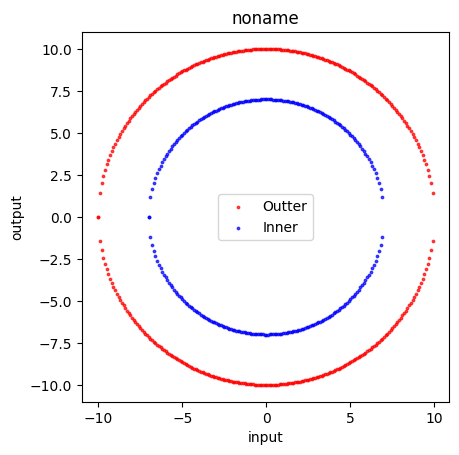

In [9]:
## 构建一个同心圆数据集，假设圆心即为坐标原点：（0,0）

step=0.1

## 外圆半径为 10 个单位长度 x^2 + y^2 = r^2
r1 = 10
X_outter = torch.arange(start=-r1, end=r1, step=step).unsqueeze(dim=1)
y_outter = torch.sqrt(r1**2 - X_outter**2)
X_outter = torch.cat((X_outter, X_outter))
y_outter = torch.cat((y_outter, -y_outter))


## 外圆半径为 7 个单位长度
r0 = 7
X_inner = torch.arange(start=-r0, end=r0, step=step).unsqueeze(dim=1)
y_inner = torch.sqrt(r0**2 - X_inner**2)
X_inner = torch.cat((X_inner, X_inner))
y_inner = torch.cat((y_inner, -y_inner))


## 可视化查看外圆和内圆
plt.gca().set_aspect('equal')   # 设置 x 和 y 轴同比例，否则变椭圆
plot(X_outter, y_outter, color="red", legend="Outter")
plot(X_inner, y_inner, color="blue", legend="Inner")

In [10]:
## 将上述的两个圆的数据转换为训练数据集，格式为：[x, y] -> 0|1，
## 0 代表该点属于内圆，1 代表该点属于外圆

points_outter = torch.concat((X_outter, y_outter), 1)
points_inner  = torch.concat((X_inner, y_inner), 1)

X = torch.concat((points_outter, points_inner), 0)
y = torch.concat((torch.ones(int(r1/step)*4).unsqueeze(1), 
               torch.zeros(int(r0/step)*4).unsqueeze(1)), 0)

In [11]:
X.shape, y.shape

(torch.Size([680, 2]), torch.Size([680, 1]))

用 pandas 的强大功能查看一下数据集的前 5 个和最后 5 个数据：

In [12]:
import pandas as pd

df = pd.DataFrame({
    "X1" : X[:, 0],
    "X2" : X[:, 1],
    "label" : y[:, 0]
})

pd.concat((df[:5], df[-5:]))

,X1,X2,label
0,-10.0,0.000000,1.0
1,-9.9,1.410676,1.0
2,-9.8,1.989975,1.0
3,-9.7,2.431050,1.0
4,-9.6,2.799999,1.0
675,6.5,-2.598076,0.0
676,6.6,-2.332381,0.0
677,6.7,-2.027315,0.0
678,6.8,-1.661324,0.0
679,6.9,-1.178982,0.0


跟所有的机器学习一样，数据集还需要被拆分为训练数据集和测试数据集。由于本例的数据集是由外圆数据和内圆数据相接而成，因此就不能像之前那种直接截取式的拆分，而是需要随机拆分，从而保证训练数据集和测试数据集中都有内圆和外圆的样本：

In [13]:
## 使用 sklearn 提供的 train_test_split 函数可以很好地拆分这种 X=>y 类型的数据集

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(544, 136, 544, 136)

In [14]:
## 查看训练数据中是否随机地包含了内圆和外圆的数据

df = pd.DataFrame({
    "X1" : X_train[:, 0],
    "X2" : X_train[:, 1],
    "y" : y_train[:, 0]
})

df[:10]

,X1,X2,y
0,6.8,-1.661324,0.0
1,-2.2,6.645299,0.0
2,6.3,-3.051229,0.0
3,-8.2,5.723635,1.0
4,0.8,6.954135,0.0
5,-1.8,6.764614,0.0
6,3.1,-6.276145,0.0
7,-3.9,9.208149,1.0
8,5.5,8.351646,1.0
9,6.3,-7.765951,1.0


从输出结果可以看出，训练数据集中既有内圆数据，又有外圆数据。说明训练数据已经被均匀地拆分为了训练数据集和测试数据集。

数据准备好了，现在就可以用前一个例子的训练循环开始训练和验证了。由于输入的数据从前例中的 1 维数据变成了 2 维数据，因此模型也要稍作修改，线性层需要接收 2 个 Features 作为输入。下面是修改后的模型：

In [15]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Features 修改为 2，因为对于本例，有 X1 和 X2 两个输入
        self.linear_layer = nn.Linear(in_features=2, out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)
    
# 将模型送入 GPU 加速
model = LinearRegressionModel()
model.to(dev)

LinearRegressionModel(
  (linear_layer): Linear(in_features=2, out_features=1, bias=True)
)

至于 loss 函数和 optimizer，以及训练循环，都沿用前例的不便。下面的代码就开始进行训练循环：

In [16]:
# 训练数据放入 GPU 加速
X_train, X_test, y_train, y_test = X_train.to(dev), X_test.to(dev), y_train.to(dev), y_test.to(dev)


epochs = 100

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model.train()

    # 1. 使用模型进行预测
    #    y_logits 保存原始输出，可能是远远大于 1 或小于 0 的数字
    y_logits = model(X_train) # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
    
    # y_pred 中保存 0 或 1 的最终结果
    # sigmoid(y_logits) 将原始的输出转换为概率
    y_pred = torch.round(torch.sigmoid(y_logits))
  
    # 2. 计算 loss 和 accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train) 
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train) 
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred) 

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model(X_test)
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.33322, Accuracy: 48.90% | Test loss: 1.23902, Test acc: 54.41%
Epoch: 10 | Loss: 1.33322, Accuracy: 48.90% | Test loss: 1.23902, Test acc: 54.41%
Epoch: 20 | Loss: 1.33322, Accuracy: 48.90% | Test loss: 1.23902, Test acc: 54.41%
Epoch: 30 | Loss: 1.33322, Accuracy: 48.90% | Test loss: 1.23902, Test acc: 54.41%
Epoch: 40 | Loss: 1.33322, Accuracy: 48.90% | Test loss: 1.23902, Test acc: 54.41%
Epoch: 50 | Loss: 1.33322, Accuracy: 48.90% | Test loss: 1.23902, Test acc: 54.41%
Epoch: 60 | Loss: 1.33322, Accuracy: 48.90% | Test loss: 1.23902, Test acc: 54.41%
Epoch: 70 | Loss: 1.33322, Accuracy: 48.90% | Test loss: 1.23902, Test acc: 54.41%
Epoch: 80 | Loss: 1.33322, Accuracy: 48.90% | Test loss: 1.23902, Test acc: 54.41%
Epoch: 90 | Loss: 1.33322, Accuracy: 48.90% | Test loss: 1.23902, Test acc: 54.41%


输出的结果看出来，我们之前的纯线性模型对这个例子中的同心圆分类问题的学习效果并不好。Loss 没有随着学习循环的次数增加而降低，准确度也没有增加，一直在 50% 左右。

但这个结果又是符合我们之前的推测的，用纯线性的模型来解决这种同心圆的非线性问题可能是达不到效果的。其原因，就是因为我们无法画一条直线将这两个同心的圆完全隔开，我们需要一个类似圆的曲线将它们隔开。而这种问题就是一个典型的非线性模型才能解决的问题。

**预测边界可视化**

---

实际上，我们可以用可视化的方法来查看模型的预测“边界”，即模型究竟画出了一条什么样的函数来对这个同心圆问题进行分类的。

在这个地方有一个非常好用的 pytorch 的帮助函数库：https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py

我们可以把它下载下来，然后用其中的 `plot_decision_boundary` 函数来对结果数据进行可视化，帮助我们理解在学习过程中模型到底发生了什么。

下面的代码将库文件下载下来，然后载入其中的 `plot_predictions` 和 `plot_decision_boundary`两个函数：

In [17]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


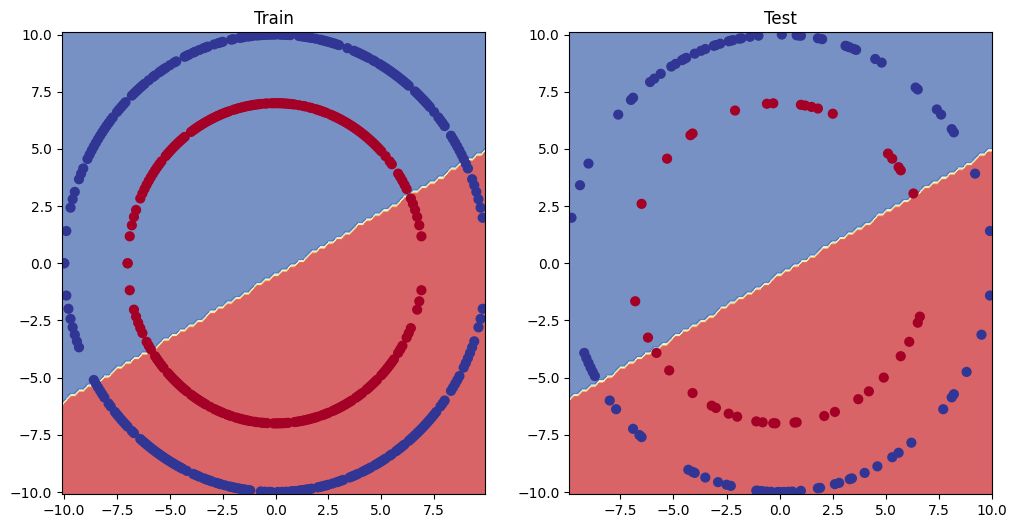

In [18]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)

从可视化的图像来看，果然模型画出了一条直线（红蓝交界处的那条斜线）。而模型会认为直线上方的都是内圈的数据，而直线下方的都是外圈的数据。这符合我们之前的猜测。

**模型优化的方法**

---

当模型没有达到预期效果的时候，模型优化可以采用的方法主要有：
1. 增加隐藏层的层数；
2. 增加神经元的个数；
3. 增加学习循环的次数；
4. 调整参数优化的步进值（lr）；
5. 调整激活函数；
6. 调整loss 函数；
7. 增大训练的数据集合；
8. 等等……

| Model improvement technique\*         | What does it do?                                                                                                                                                                                                             |
| ------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Add more layers**                   | Each layer _potentially_ increases the learning capabilities of the model with each layer being able to learn some kind of new pattern in the data, more layers is often referred to as making your neural network _deeper_. |
| **Add more hidden units**             | Similar to the above, more hidden units per layer means a _potential_ increase in learning capabilities of the model, more hidden units is often referred to as making your neural network _wider_.                          |
| **Fitting for longer (more epochs)**  | Your model might learn more if it had more opportunities to look at the data.                                                                                                                                                |
| **Changing the activation functions** | Some data just can't be fit with only straight lines (like what we've seen), using non-linear activation functions can help with this (hint, hint).                                                                          |
| **Change the learning rate**          | Less model specific, but still related, the learning rate of the optimizer decides how much a model should change its parameters each step, too much and the model overcorrects, too little and it doesn't learn enough.     |
| **Change the loss function**          | Again, less model specific but still important, different problems require different loss functions. For example, a binary cross entropy loss function won't work with a multi-class classification problem.                 |
| **Use transfer learning**             | Take a pretrained model from a problem domain similar to yours and adjust it to your own problem. We cover transfer learning in [notebook 06](https://www.learnpytorch.io/06_pytorch_transfer_learning/).                    |

由于上述的方法都是可以人为进行调整的，因此它们叫做 **Hyperparameters**。这是相对于人为无法调整的模型内部参数而言的。

为了进一步验证，我们的模型是真的无法处理同心圆数据集，我们可以尝试一些优化措施，看优化后是否能改进我们的学习效果。

下面的代码我们主要采取了几种优化措施：
1. 增加了隐藏层数；
2. 增加了每层的神经元个数；
3. 增加了循环次数。

下面是修改后的模型：

In [24]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        # 第一层，处理输入点坐标（2 个 Features），并且输出 10 个 Features 给下一层
        self.linear_layer1 = nn.Linear(in_features=2, out_features=10)

        # 第二层，处理输入的 10 个 Features，并且输出 10 个 Features 给下一层
        self.linear_layer2 = nn.Linear(in_features=10, out_features=10)

        # 第三层，处理输入的 10 个 Features，并且输出 1 个 Row Result 给外界
        self.linear_layer3 = nn.Linear(in_features=10, out_features= 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # 第一层的输出，是第二层的输入，第二层的输出是第三层的输入
        return self.linear_layer3(
                    self.linear_layer2(
                        self.linear_layer1(x)
                    )
                )
    
# 将模型送入 GPU 加速
model = LinearRegressionModel()
model.to(dev)

LinearRegressionModel(
  (linear_layer1): Linear(in_features=2, out_features=10, bias=True)
  (linear_layer2): Linear(in_features=10, out_features=10, bias=True)
  (linear_layer3): Linear(in_features=10, out_features=1, bias=True)
)

注意的一点是，前一层输出的 Features 个数（out_features）一定要等于下一层的输入 Features 的个数（in_features）。

上面的写法是手动的。实际上，神经网络的构建几乎都遵循这种模式，即按顺序为模型创建层次。PyTorch 为这种模式提供了一种便利的写法，即 `nn.Sequential()` 函数，它可以创建多个层次，并且将它们首尾相连。

上面的模型如果用 `nn.Sequential()` 来写，可以简化为这样：

```python
# Replicate model with nn.Sequential
model = nn.Sequential(
    nn.Linear(in_features=2, out_features=128),
    nn.Linear(in_features=128, out_features=128)，
    nn.Linear(in_features=128, out_features=1)，
).to(device)
```

下面是增加循环次数后的学习循环，循环从 100 次变为了 500 次，然后再看看学习的效果：

In [25]:
# 训练数据放入 GPU 加速
X_train, X_test, y_train, y_test = X_train.to(dev), X_test.to(dev), y_train.to(dev), y_test.to(dev)


# 模型新建了，重新传递模型参数列表给 optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

epochs = 500

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model.train()

    # 1. 使用模型进行预测
    #    y_logits 保存原始输出，可能是远远大于 1 或小于 0 的数字
    y_logits = model(X_train) # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
    
    # y_pred 中保存 0 或 1 的最终结果
    # sigmoid(y_logits) 将原始的输出转换为概率
    y_pred = torch.round(torch.sigmoid(y_logits))
  
    # 2. 计算 loss 和 accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train) 
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train) 
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred) 

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model(X_test)
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.88690, Accuracy: 47.98% | Test loss: 0.69087, Test acc: 50.00%
Epoch: 100 | Loss: 0.68543, Accuracy: 56.07% | Test loss: 0.65523, Test acc: 69.85%
Epoch: 200 | Loss: 0.68543, Accuracy: 56.07% | Test loss: 0.65524, Test acc: 69.85%
Epoch: 300 | Loss: 0.68543, Accuracy: 56.07% | Test loss: 0.65524, Test acc: 69.85%
Epoch: 400 | Loss: 0.68543, Accuracy: 56.07% | Test loss: 0.65524, Test acc: 69.85%


从优化后的模型的学习效果来看，情况并没有得到改善。Loss 并没有减少，accuracy 也没有随着训练次数而增加。

从前面的观察和分析看来，解决同心圆的分类问题，就不能使用纯的线性的模型了。因此，我们需要将模型转换为**非线性模型**。

那么什么是非线性的模型呢？听上去复杂的问题，实际上实现起来却非常简单。因为我们只需要让每一层隐藏层之间能够发生“突变”，或者叫做“转弯”。为了达到这个目的，我们要在每一层之间加入一个新的层次。

新的层次要做的事情，就是要将这种线性关系打破。这就跟激活函数要做的事情是一样的，把一个输入范围转换到另一种输出的范围。

实际上，这种转换在我们的 loss 函数（BCEWithLogitsLoss）中已经有过，即 sigmoid 函数。但我们只使用 sigmoid 函数来进行 loss 计算，而并没有在神经网络的层次之间进行过这种转换。

另外，从大量的例子来看，sigmoid 对于需要发生“突变”或“拐弯”的函数效果并不太好。因为在使用 sigmoid 函数时，当神经元输出接近于 0 或 1 时，它的梯度将趋近于 0，导致信息无法传递到更深的层次，从而使得网络的训练过程受到限制。

**激活函数 sigmoid 和 ReLU**

---

为了了解个问题的实质，可以从 sigmoid 函数的本质入手。sigmoid 本质上是将任意的输入映射到 0-1 之间的输出，输入越接近无穷大，输出越接近 1。输入越接近无穷小，输出越接近 0。

它的函数形式是这样的：

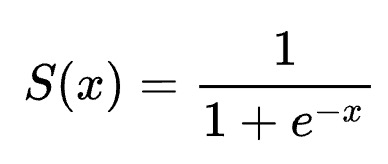

sigmoid 的函数曲线是这样的：

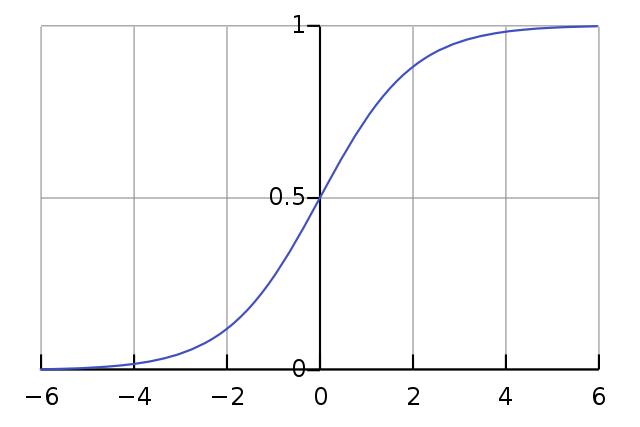


而目前更加常用的是 **ReLU** 函数，ReLU 函数（Rectified Linear Unit）在计算和训练时具有更好的表现和效率，特别是在较深的神经网络中。

ReLU 函数的计算速度非常快，因为它只需要计算一个 max 操作，相比 sigmoid 函数的指数计算要快得多。这使得 ReLU 函数在计算量较大的深度神经网络中更加高效。

其次，ReLU 函数不会出现梯度消失的问题。

最后，ReLU 函数的非线性特性能够使得网络具有更好的表示能力，可以更好地学习和拟合非线性模式。相比之下，sigmoid 函数的非线性特性在输出接近于 0 或 1 时变得非常平缓，这会限制网络的表示能力。

ReLU 函数的形式非常简单，即对于小于 0 的输入，输出 0，大于 0 的输入，输出原始输入数据：

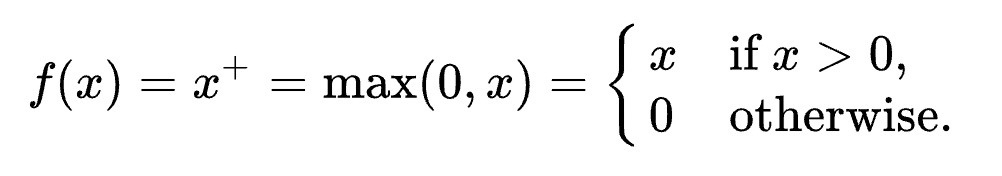

ReLU 函数的曲线如下：

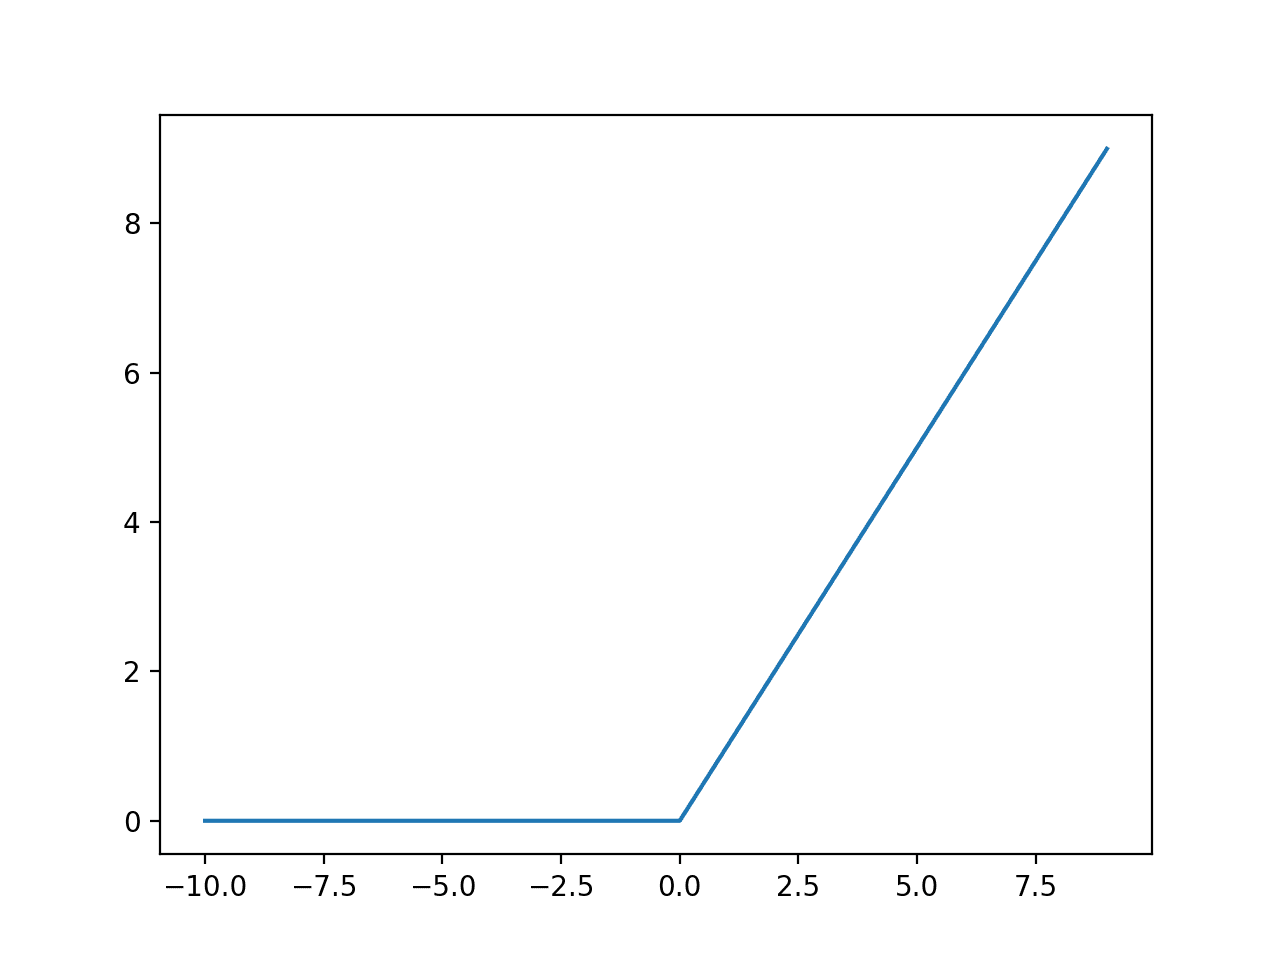

---

总而言之，我们需要在神经网络的每一层线性层之间进行一次转换，使得神经网络具备变化的能力。而这种变化，可以通过增加一层激活函数来实现。我们的例子里，将使用 ReLU 函数来实现这种转变。

下面的代码重新创建了我们的模型，在其中增加了 ReLU 层。这次的模型使用了 `nn.Sequential()` 方法：

In [21]:
model = nn.Sequential(
    nn.Linear(in_features=2, out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=1),
).to(dev)

新的模型中，我们在每一层中间加入了 ReLU 层，负责让线性模型变化为一个非线性模型。

模型建好之后，我们再不厌其烦地进行学习循环，看看学习效果是否得到改进：

In [22]:
# 训练数据放入 GPU 加速
X_train, X_test, y_train, y_test = X_train.to(dev), X_test.to(dev), y_train.to(dev), y_test.to(dev)

# 模型新建了，重新传递模型参数列表给 optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

epochs = 500

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model.train()

    # 1. 使用模型进行预测
    y_logits = model(X_train) # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
    
    # y_pred 中保存 0 或 1 的最终结果
    # sigmoid(y_logits) 将原始的输出转换为概率
    y_pred = torch.round(torch.sigmoid(y_logits))
  
    # 2. 计算 loss 和 accuracy
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train) 
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred) 

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model(X_test)
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 50 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.67659, Accuracy: 53.31% | Test loss: 0.57924, Test acc: 69.85%
Epoch: 50 | Loss: 0.57174, Accuracy: 56.07% | Test loss: 0.59408, Test acc: 76.47%
Epoch: 100 | Loss: 0.51642, Accuracy: 56.07% | Test loss: 0.50319, Test acc: 97.79%
Epoch: 150 | Loss: 0.47145, Accuracy: 56.07% | Test loss: 0.49046, Test acc: 100.00%
Epoch: 200 | Loss: 0.46380, Accuracy: 56.07% | Test loss: 0.46740, Test acc: 100.00%
Epoch: 250 | Loss: 0.45400, Accuracy: 56.07% | Test loss: 0.49968, Test acc: 89.71%
Epoch: 300 | Loss: 0.46442, Accuracy: 56.07% | Test loss: 0.48532, Test acc: 88.24%
Epoch: 350 | Loss: 0.48247, Accuracy: 56.07% | Test loss: 0.44871, Test acc: 93.38%
Epoch: 400 | Loss: 0.39452, Accuracy: 61.95% | Test loss: 0.36875, Test acc: 100.00%
Epoch: 450 | Loss: 0.39605, Accuracy: 56.07% | Test loss: 0.33802, Test acc: 100.00%


从输出的结果来看，加入 ReLU 层后，简直好太多了，最后的分类成功率达到了 100%，甚至还没用到之前那么多次的训练循环。我们将最后的模型放入到 `plot_decision_boundary()` 函数中进行可视化：

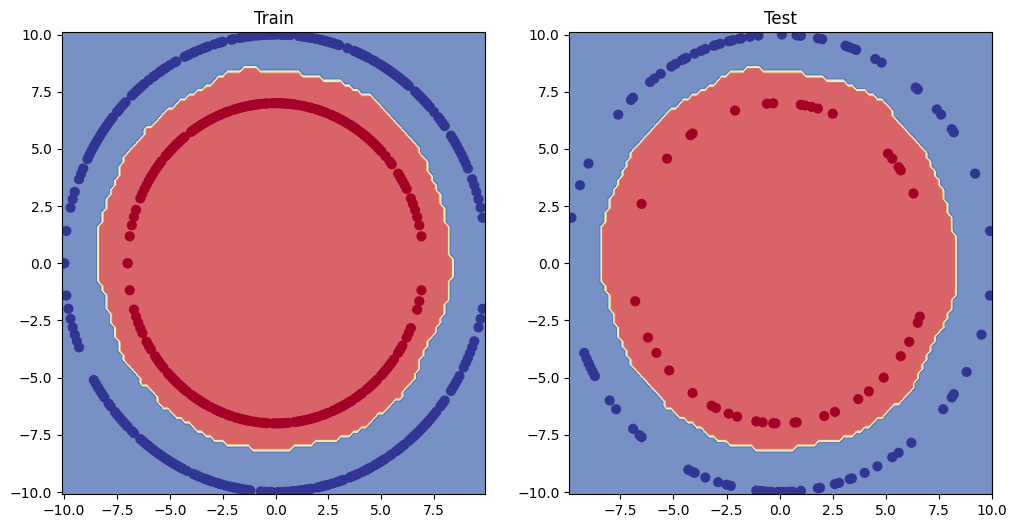

In [23]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)

我们看到模型训练后画出的边界线是一个近乎完美的圆形边界线，完美地区分了内圆和外圆。

这就是通过在每一层之间加入 ReLU 非线性函数，让将纯线性模型转变为非线性模型带来的效果。

### 总结

---

- 线性模型可能可以解决一部分非线性的问题，但不能解决全部；
- 对于非线性模型，应该在层间使用 ReLU 或 sigmoid 函数；
- 解决不同类型的问题应该使用不同的 loss 函数，例如回归问题使用 `L1Loss` 函数（实现 MAE 算法），而解决分类问题应该使用 `BCELoss` 或 `BCEWithLogitsLoss` 函数（实现 Binary Cross Entropy 算法）；
- 相比 loss 函数，optimizer 具有更好的通用性，例如 SGD 和 Adam Optimizer 都可以解决相当多种类的问题；
- 优化模型的方式有很多种，这些认为可调的参数叫做 **Hyperparameters**。